In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pyhf import runOnePoint

def prep_data(observed_counts,backgrounds_incl_uncert,nominal_signals):
    constants = []
    actual_data = []
    constraint_data = []
    
    for n, b_incl_uncert, snom in zip(observed_counts,backgrounds_incl_uncert,nominal_signals):
        b, deltab = b_incl_uncert
        tau = b/deltab/deltab
        actual_data.append(n)
        constraint_data.append(tau*b)
        constants.append(tau)

    data = actual_data + constraint_data
    s = lambda mu: [mu*snom for snom in nominal_signals]  # signal_counts as function of signal strength
    return data, constants, s
    
def CLsOnePoint(muTest, observed_counts,backgrounds_incl_uncert,nominal_signals, init_pars,par_bounds):
    data, constants, s = prep_data(observed_counts,backgrounds_incl_uncert,nominal_signals)
    clsobs, cls_exp = runOnePoint(muTest, data,constants,s,init_pars,par_bounds)[-2:]
    return 1./clsobs, [1./x for x in cls_exp]

In [3]:
def invert_interval(testmus,cls_obs, cls_exp, test_size = 0.05):
    point05cross = {'exp':[],'obs':None}
    for cls_exp_sigma in cls_exp:
        yvals = [x for x in cls_exp_sigma]
        point05cross['exp'].append(np.interp(test_size,list(reversed(yvals)),list(reversed(testmus))))
        
    yvals = cls_obs
    point05cross['obs'] = np.interp(test_size,list(reversed(yvals)),list(reversed(testmus)))
    return point05cross

In [4]:
def plot_results(testmus,cls_obs, cls_exp, test_size = 0.05):
    plt.plot(mutests,cls_obs, c = 'k')
    for i,c in zip(range(5),['grey','grey','grey','grey','grey']):
        plt.plot(mutests,cls_exp[i], c = c)
    plt.plot(testmus,[test_size]*len(testmus), c = 'r')
    plt.ylim(0,1)


ON MU=1
CLs: obs 39.5292986164 exp: [10753.709914097957, 995.9775686044846, 107.17314694836956, 15.34369495086931, 3.5619886159328624]
RUN SCAN


/Users/lukas/Code/histfactory/pyhf/pyhf/__init__.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  CLs  = CLb/CLsb


{'exp': [0.4425802017617599,
  0.5752406915805164,
  0.7716556141137679,
  1.055068561661205,
  1.3815292546256284],
 'obs': 0.8990904067366252}

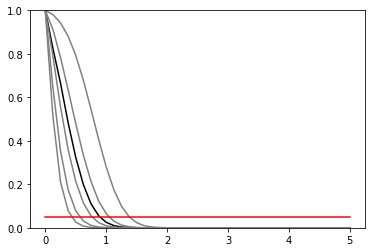

In [5]:
source = {
  "binning": [2,-0.5,1.5],
  "bindata": {
    "data":    [120.0, 145.0],
    "bkg":     [100.0, 150.0],
    "bkgerr":  [15.0, 20.0],
    "sig":     [30.0, 45.0]
  }
}
# import json
# source = json.load(open('./data/source.json'))


my_observed_counts = source['bindata']['data']
my_background_counts = zip(source['bindata']['bkg'],source['bindata']['bkgerr'])
my_signal_counts = source['bindata']['sig']
init_pars = [1.0] + [b[0] for b in my_background_counts]
par_bounds = [[0,10]] + [[0.5*b,2.*b] for b,db in my_background_counts]

print 'ON MU=1'
d = CLsOnePoint(1.0,my_observed_counts,my_background_counts,my_signal_counts,init_pars,par_bounds)
print 'CLs: obs {} exp: {}'.format(1./d[-2],[1./x for x in d[-1]])

print 'RUN SCAN'
mutests = np.linspace(0,5,41)
tests = [CLsOnePoint(muTest,my_observed_counts,my_background_counts,my_signal_counts,init_pars,par_bounds) for muTest in mutests]
cls_obs = [test[0]  for test in tests]
cls_exp = [[test[1][i]  for test in tests] for i in range(5)]

plot_results(mutests, cls_obs, cls_exp)

invert_interval(mutests, cls_obs, cls_exp)

In [14]:
d,c,s = prep_data(my_observed_counts,my_background_counts,my_signal_counts)
from pyhf import model_expected_actualdata, unconstrained_bestfit

binning = source['binning']

nominal_nuis = [b for b,db in my_background_counts]
nom_bonly = model_expected_actualdata(s, 0.0, nominal_nuis, c)
nom_sb = model_expected_actualdata(s, 1.0, nominal_nuis, c)

bestfit_pars  = unconstrained_bestfit(d,c,s,init_pars,par_bounds)
bestfit_cts = model_expected_actualdata(s, bestfit_pars[0], bestfit_pars[1:], c)

def plot_histo(ax, binning, data):
    bin_width = (binning[2]-binning[1])/binning[0]
    bin_leftedges = np.linspace(binning[1],binning[2],binning[0]+1)[:-1]
    bin_centers = [le + bin_width/2. for le in bin_leftedges]
    ax.bar(bin_centers,data,1, alpha=0.5)


def plot_data(ax, binning, data):
    errors = [math.sqrt(d) for d in data]
    bin_width = (binning[2]-binning[1])/binning[0]
    bin_leftedges = np.linspace(binning[1],binning[2],binning[0]+1)[:-1]
    bin_centers = [le + bin_width/2. for le in bin_leftedges]    
    ax.bar(bin_centers,data,0, yerr=errors, linewidth=0, error_kw = dict(ecolor='k', elinewidth = 1))
    ax.scatter(bin_centers, data, c = 'k')


(0, 300)

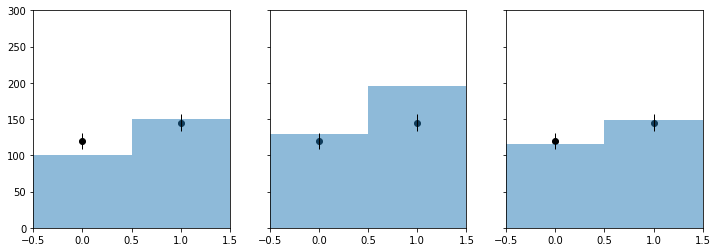

In [15]:
f,axarr = plt.subplots(1,3,sharey=True)
f.set_size_inches(12,4)

plot_histo(axarr[0], binning, nom_bonly)
plot_data(axarr[0], binning, my_observed_counts)
axarr[0].set_xlim(binning[1:])

plot_histo(axarr[1], binning, nom_sb)
plot_data(axarr[1], binning, my_observed_counts)
axarr[1].set_xlim(binning[1:])

plot_histo(axarr[2], binning, bestfit_cts)
plot_data(axarr[2], binning, my_observed_counts)
axarr[2].set_xlim(binning[1:])

plt.ylim(0,300)

In [16]:
##
##  DUMMY 2D thing
##

def signal(m1,m2):
    x = np.linspace(100,1000)
    massscale = 600.
    minmass = 100.
    countscale = 100
    
    effective_mass = np.sqrt(m1**2 + m2**2)
    return [countscale*np.exp(-(effective_mass-minmass)/massscale), 0]

@np.vectorize
def cls(m1,m2):
    signal_counts = signal(m1,m2)
    clsobs, clsexp = CLsOnePoint(1.0,my_observed_counts,my_background_counts,signal_counts,init_pars,par_bounds)[-2:]
    return clsobs


In [17]:
x = np.linspace(100,1000)
y = np.linspace(100,1000)

In [18]:
grid = grid_x, grid_y = np.mgrid[100:1000:10j,100:1000:10j]
X = grid.T.reshape(10*10,2)
y = cls(X[:,0],X[:,1])

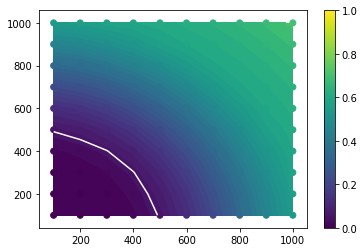

In [19]:
from scipy.interpolate import griddata
interpolated = griddata(X, y, (grid_x, grid_y), method='linear')

plt.contourf(grid_x, grid_y, interpolated, levels = np.linspace(0,1))
plt.scatter(X[:,0],X[:,1], c = y, vmin = 0, vmax = 1)
plt.colorbar()
plt.contour(grid_x, grid_y, interpolated, levels = [0.05], colors = 'w')